In [35]:
# 기본 세팅
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import gaussian_kde
from matplotlib import colors as mpl_colors
import os
import argparse
from datetime import datetime
from glob import glob
from itertools import product, groupby
from mpl_toolkits.mplot3d import Axes3D
import re

In [36]:
# font = {'family': 'Tahoma'}
# font = {'family': 'Times New Roman'}

# plt.rc('font', **font)

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

### Options

In [37]:
save_formats = ['png', 'pdf', 'svg']
device = 'nano'
max_cores = 4
models = ['densenet201']

In [38]:
def LayerNum(model):
    if model == "densenet201" :
        return 306
    elif model == "resnet152" :
        return 206
    elif model == "enetb0" :
        return 136
    elif model == "csmobilenet-v2" :
        return 81
    elif model == "squeezenet" :
        return 50
    elif model == "yolov7" :
        return 143
    elif model == "yolov7-tiny" :
        return 99
    elif model == "yolov4" :
        return 162
    elif model == "yolov4-tiny" :
        return 38
    elif model == "resnet10" :
        return 17
    elif model == "yolov2-tiny" :
        return 16
    else :
        print("Unknown model: ", model)
        return 0
    
for model in models:
    for save_format in save_formats:
        directory_path = f'./{model}/{save_format}'
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)
            print(f"디렉터리 '{directory_path}' 생성 완료!")
        else:
            print(f"디렉터리 '{directory_path}'가 이미 존재합니다.")

디렉터리 './densenet201/png'가 이미 존재합니다.
디렉터리 './densenet201/pdf'가 이미 존재합니다.
디렉터리 './densenet201/svg'가 이미 존재합니다.


### Load csv & Dataframe 생성

In [39]:
model = 'densenet201'
date = 'data-0107'

In [40]:
gpu_file_path = f"../../csv/{date}/layer_time/{model}/gpu_raw_data.csv"
cpu_file_path = f"../../csv/{date}/layer_time/{model}/cpu_raw_data_01blas.csv"

In [41]:
set_model = "real"     # toy, real

if set_model == "toy": num_thread = 10
elif set_model == "real": num_thread = 8
else: print("SetModel!!!!!!\n")

if set_model == "toy": mode_list = ["GPU >>> CPU", "GPU >> CPU", "GPU > CPU", "GPU > CPU | GPU < CPU"]
elif set_model == "real": mode_list = ["yolov7-tiny", "densenet201", "enetb0"]
else: print("Unknown set_model")

model = "densenet201"

if set_model == "toy":
    e_preprocess = 10
    e_postprocess = 10

    if model == "GPU >>> CPU":
        # GPU >>> CPU
        cpu_inference_list = [200,400,350,460,570,330,250,290,310,300]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    if model == "GPU >> CPU":
        # GPU >>> CPU
        cpu_inference_list = [100,200,150,260,270,130,50,90,110,30]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    elif model == "GPU > CPU":
        # GPU > CPU
        cpu_inference_list = [10,20,15,26,27,13,5,9,11,3]
        gpu_inference_list = [1,3,2,5,7,8,1,3,4,1]
    elif model == "GPU > CPU | GPU < CPU":
        # # GPU CPU 반반 (앞이 GPU 효율 좋음)
        cpu_inference_list = [10,20,15,26,27,13,5,9,11,3]
        gpu_inference_list = [1,3,2,5,7,18,14,15,18,5]
    else: print("Unknown mode")
        
elif set_model == "real": 
    # CSV 파일 경로 설정
    # file_path = f'../../csv/data-0516/sequential-multiblas/{mode}/sequential_01blas.csv'
    
    # CSV 파일 읽기
    df = pd.read_csv(cpu_file_path)
    
    e_preprocess = np.mean(df["e_preprocess"])
    e_postprocess = np.mean(df["e_postprocess"])
    
    # 'layer'로 시작하는 모든 열 찾기
    layer_columns = [col for col in df.columns if col.startswith('layer')]
    
    # 각 'layer' 열의 평균 계산
    layer_num = 0
    layer_averages_cpu = {}
    for col in layer_columns:
        # 열 제목에서 숫자만 추출
        col_number = int(re.search(r'\d+', col).group())
        # 해당 열의 평균 계산 및 저장
        layer_averages_cpu[col_number] = df[col].mean()
        if layer_num < col_number : layer_num = col_number
    
    # CSV 파일 경로 설정
    # file_path = f'../data/data-0516/layer_time/{mode}/gpu_layer_time.csv'
    
    # CSV 파일 읽기
    df = pd.read_csv(gpu_file_path)
    
    # 'layer'로 시작하는 모든 열 찾기
    layer_columns = [col for col in df.columns if col.startswith('layer')]
    
    # 각 'layer' 열의 평균 계산
    layer_num = 0
    layer_averages_gpu = {}
    for col in layer_columns:
        # 열 제목에서 숫자만 추출
        col_number = int(re.search(r'\d+', col).group())
        # 해당 열의 평균 계산 및 저장
        layer_averages_gpu[col_number] = df[col].mean()
        if layer_num < col_number : layer_num = col_number
    
    # CPU와 GPU 인퍼런스 리스트 생성
    cpu_inference_list = list(layer_averages_cpu.values())
    gpu_inference_list = list(layer_averages_gpu.values())

else: print("Unknown!!!")
    
# 거꾸로!!
# cpu_inference_list = cpu_inference_list[::-1]
# gpu_inference_list = gpu_inference_list[::-1]

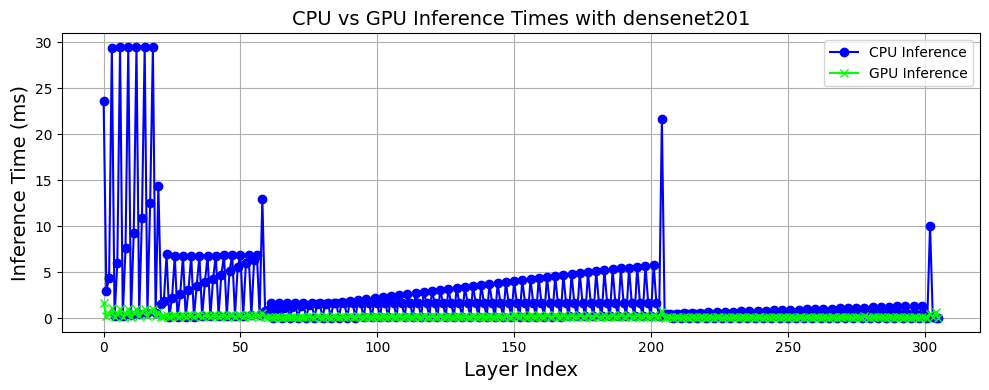

In [42]:
# 그래프 그리기
plt.figure(figsize=(10, 4))
plt.plot(cpu_inference_list, label='CPU Inference', marker='o', linestyle='-', color = 'blue')
plt.plot(gpu_inference_list, label='GPU Inference', marker='x', linestyle='-', color='lime')

# 그래프 제목 및 레이블 설정
plt.title(f'CPU vs GPU Inference Times with {model}', fontsize=14)
plt.xlabel('Layer Index', fontsize=14)
plt.ylabel('Inference Time (ms)', fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{model}/{save_format}/0.LayerTime_{device}_simul_{set_model}_{model}.{save_format}')

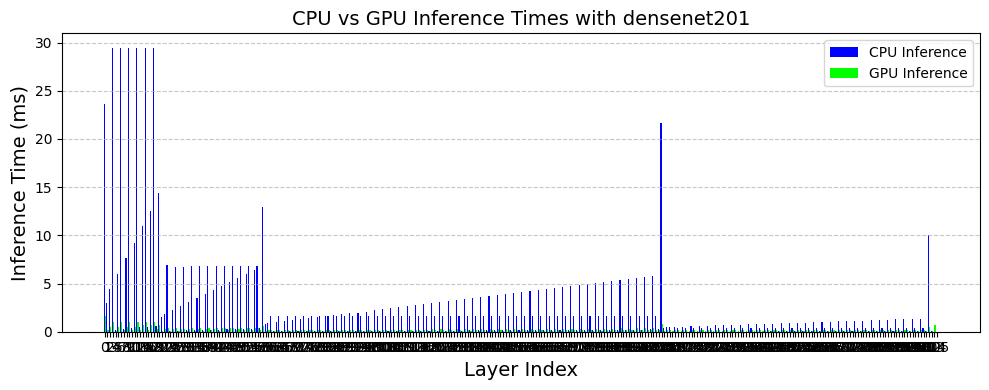

In [43]:
# 레이어 인덱스 생성
layer_indices = np.arange(len(cpu_inference_list))

# 그래프 그리기
plt.figure(figsize=(10, 4))

# CPU 막대 (연한 노란색)
plt.bar(layer_indices - 0.2, cpu_inference_list, width=0.4, label='CPU Inference', color='blue')

# GPU 막대 (연한 파란색)
plt.bar(layer_indices + 0.2, gpu_inference_list, width=0.4, label='GPU Inference', color='lime')

# 그래프 제목 및 레이블 설정
plt.title(f'CPU vs GPU Inference Times with {model}', fontsize=14)
plt.xlabel('Layer Index', fontsize=14)
plt.ylabel('Inference Time (ms)', fontsize=14)
plt.xticks(layer_indices)  # X축 인덱스 설정
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Y축 격자만 추가

plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{model}/{save_format}/00.LayerTime_{device}_simul_{set_model}_{model}.{save_format}')

In [44]:
if set_model == "toy": 
    num_thread = 10
    contention_overhead_percent = 10  # Example contention overhead percentage
elif set_model == "real": 
    num_thread = 4
    contention_overhead_percent = 0  # Example contention overhead percentage
    
else: print("SetModel!!!!!!\n")

In [45]:
# Calculations for Sequential (Full CPU)
e_inference_cpu = sum(cpu_inference_list)
delay_seq_cpu = e_preprocess + e_inference_cpu + e_postprocess
throughput_seq_cpu = 1 / delay_seq_cpu * 1000
block_loss_seq_cpu = 0

# Calculations for Pipeline (Full CPU)
max_stage_cpu = max(e_preprocess, e_inference_cpu, e_postprocess)
if max_stage_cpu == e_preprocess:
    pipeline_stall_cpu = e_preprocess - e_inference_cpu
elif max_stage_cpu == e_inference_cpu:
    pipeline_stall_cpu = e_inference_cpu - e_preprocess
else:
    pipeline_stall_cpu = e_postprocess - e_preprocess + e_postprocess - e_inference_cpu
delay_tpa_cpu = e_preprocess + e_inference_cpu + e_postprocess + pipeline_stall_cpu
throughput_tpa_cpu = 1 / max_stage_cpu * 1000

# Calculations for Data-parallel (Full CPU)
contention_overhead_cpu = (delay_seq_cpu * contention_overhead_percent) / 100
delay_dpa_cpu = delay_seq_cpu + contention_overhead_cpu
throughput_dpa_cpu = 1 / (delay_dpa_cpu / num_thread) * 1000
block_loss_dpa_cpu = 0
delay_dpa_cpu = delay_dpa_cpu + block_loss_dpa_cpu

# Calculations for Sequential (Full GPU)
e_inference_gpu = sum(gpu_inference_list)
delay_seq_gpu = e_preprocess + e_inference_gpu + e_postprocess
throughput_seq_gpu = 1 / delay_seq_gpu * 1000
block_loss_seq_gpu = 0

# Calculations for Pipeline (Full GPU)
max_stage_gpu = max(e_preprocess, e_inference_gpu, e_postprocess)
if max_stage_gpu == e_preprocess:
    pipeline_stall_gpu = e_preprocess - e_inference_gpu
elif max_stage_gpu == e_inference_gpu:
    pipeline_stall_gpu = e_inference_gpu - e_preprocess
else:
    pipeline_stall_gpu = e_postprocess - e_preprocess + e_postprocess - e_inference_gpu
delay_tpa_gpu = e_preprocess + e_inference_gpu + e_postprocess + pipeline_stall_gpu
throughput_tpa_gpu = 1 / max_stage_gpu * 1000

# Calculations for Data-parallel (Full GPU)
contention_overhead_gpu = (delay_seq_gpu * contention_overhead_percent) / 100
delay_dpa_gpu = delay_seq_gpu + contention_overhead_gpu
throughput_dpa_gpu = 1 / max(delay_dpa_gpu / num_thread, e_inference_gpu) * 1000
block_loss_dpa_gpu = e_inference_gpu * (num_thread-1) - (e_preprocess+e_postprocess)
if block_loss_dpa_gpu < 0 : block_loss_dpa_gpu = 0
delay_dpa_gpu = delay_dpa_gpu + block_loss_dpa_gpu

# Results
labels = ['Seq\n(Full CPU)', 'TPA\n(Full CPU)', 'DPA\n(Full CPU)', 'Seq\n(Full GPU)', 'TPA\n(Full GPU)', 'DPA\n(Full GPU)']
delays = [delay_seq_cpu, delay_tpa_cpu, delay_dpa_cpu, delay_seq_gpu, delay_tpa_gpu, delay_dpa_gpu]
throughputs = [throughput_seq_cpu, throughput_tpa_cpu, throughput_dpa_cpu, throughput_seq_gpu, throughput_tpa_gpu, throughput_dpa_gpu]
block_losses = [block_loss_seq_cpu, pipeline_stall_cpu, block_loss_dpa_cpu, block_loss_seq_gpu, pipeline_stall_gpu, block_loss_dpa_gpu]

# Re-plotting with modifications

# Define colors for different parts
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

# Define center line position
center_x = len(labels) / 2 - 0.5

# Adding text labels on top of bars


# Graph

##### 1. Average Frame Rate

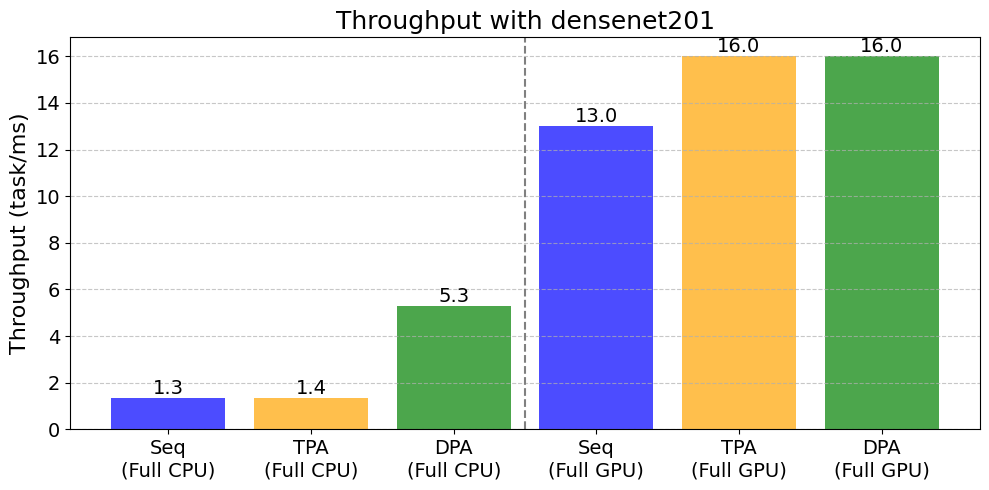

In [46]:
# Throughput
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, throughputs, color=colors[:3], alpha=0.7)
plt.axvline(x=center_x, color='gray', linestyle='--', linewidth=1.5)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1f}', ha='center', va='bottom', fontsize=14)
plt.title(f"Throughput with {model}", fontsize=18)
plt.ylabel("Throughput (task/ms)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Y축 격자만 추가

plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{model}/{save_format}/1.throughput_{device}_simul_{set_model}_{model}.{save_format}')

##### 2. Average Execution Time

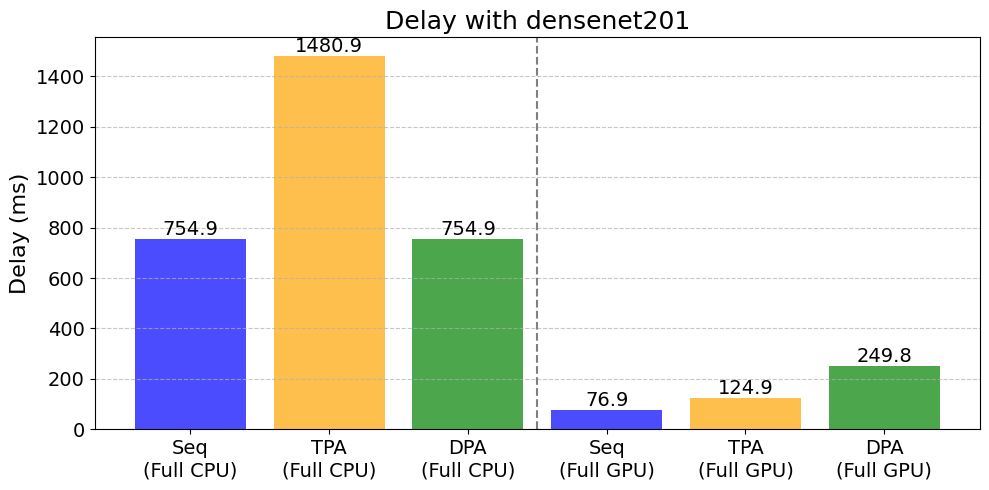

In [47]:
# Delay
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, delays, color=colors[:3], alpha=0.7)
plt.axvline(x=center_x, color='gray', linestyle='--', linewidth=1.5)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1f}', ha='center', va='bottom', fontsize=14)
plt.title(f"Delay with {model}", fontsize=18)
plt.ylabel("Delay (ms)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Y축 격자만 추가
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{model}/{save_format}/2.Delay_{device}_simul_{set_model}_{model}.{save_format}')

##### 3. Block Loss / Pipeline stall

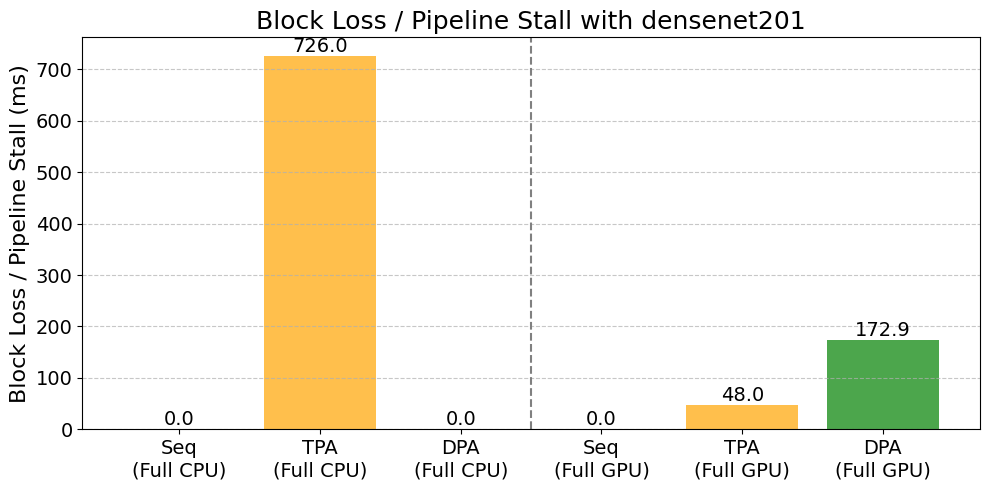

In [48]:
# Block Loss / Pipeline Stall
plt.figure(figsize=(10, 5))
bars = plt.bar(labels, block_losses, color=colors[:3], alpha=0.7)
plt.axvline(x=center_x, color='gray', linestyle='--', linewidth=1.5)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1f}', ha='center', va='bottom', fontsize=14)
plt.title(f"Block Loss / Pipeline Stall with {model}", fontsize=18)
plt.ylabel("Block Loss / Pipeline Stall (ms)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Y축 격자만 추가
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{model}/{save_format}/3.BlockLoss_{device}_simul_{set_model}_{model}.{save_format}')

##### 4. Acceleration Gain

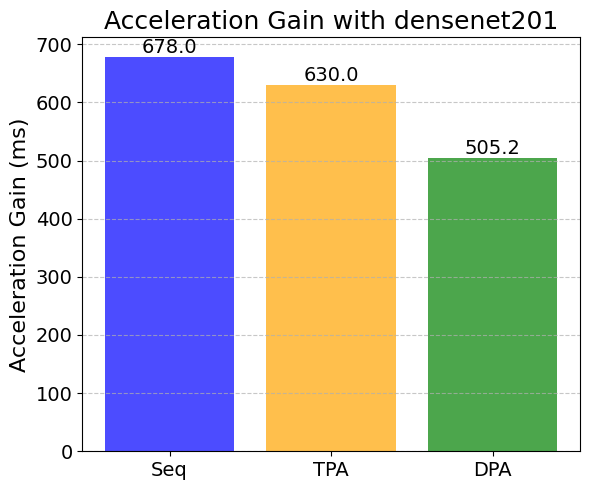

In [49]:
# Calculating acceleration gain
acceleration_gains = [
    delay_seq_cpu - delay_seq_gpu,
    delay_seq_cpu - delay_tpa_gpu,
    delay_seq_cpu - delay_dpa_gpu
]

# Labels for acceleration gain
gain_labels = ['Seq', 'TPA', 'DPA']

# Plotting acceleration gain
plt.figure(figsize=(6, 5))
bars = plt.bar(gain_labels, acceleration_gains, color=['blue', 'orange', 'green'], alpha=0.7)

# Adding text labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.1f}', ha='center', va='bottom', fontsize=14)

# Title and labels
plt.title(f"Acceleration Gain with {model}", fontsize=18)
plt.ylabel("Acceleration Gain (ms)", fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Y축 격자만 추가
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{model}/{save_format}/4.AccelerationGain_{device}_simul_{set_model}_{model}.{save_format}')

##### 5. Delay Component

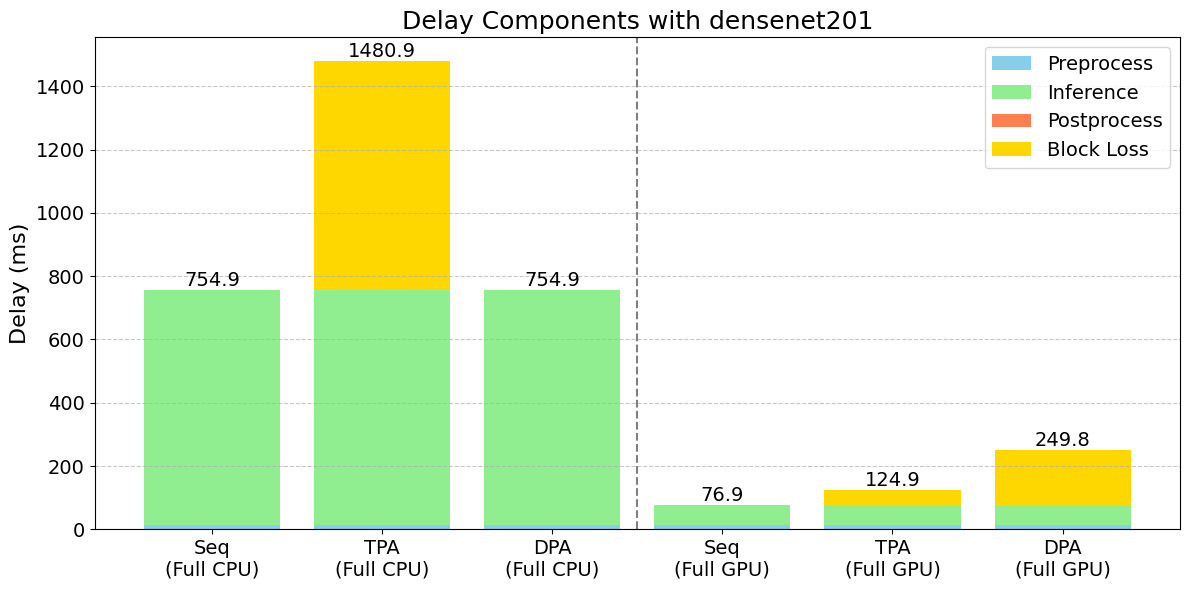

In [50]:
# Stacked bar plot for delay components (Pre, Infer, Post, Block Loss)

# Components for each architecture
pre_components = [e_preprocess] * 6
infer_components = [e_inference_cpu, e_inference_cpu, e_inference_cpu,
                    e_inference_gpu, e_inference_gpu, e_inference_gpu]
post_components = [e_postprocess] * 6
block_components = [block_loss_seq_cpu, pipeline_stall_cpu, block_loss_dpa_cpu,
                    block_loss_seq_gpu, pipeline_stall_gpu, block_loss_dpa_gpu]

# Plotting
plt.figure(figsize=(12, 6))
bar1 = plt.bar(labels, pre_components, color='skyblue', label='Preprocess')
bar2 = plt.bar(labels, infer_components, bottom=pre_components, color='lightgreen', label='Inference')
bar3 = plt.bar(labels, post_components,
               bottom=np.array(pre_components) + np.array(infer_components), color='coral', label='Postprocess')
bar4 = plt.bar(labels, block_components,
               bottom=np.array(pre_components) + np.array(infer_components) + np.array(post_components),
               color='gold', label='Block Loss')

# Add text labels
for i in range(len(labels)):
    total_height = (pre_components[i] + infer_components[i] +
                    post_components[i] + block_components[i])
    plt.text(i, total_height, f'{total_height:.1f}', ha='center', va='bottom', fontsize=14)

# Title, labels, legend
plt.title(f"Delay Components with {model}", fontsize=18)
plt.ylabel("Delay (ms)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(x=center_x, color='gray', linestyle='--', linewidth=1.5)
plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability
plt.tight_layout()
for save_format in save_formats:
    plt.savefig(f'./{model}/{save_format}/5.DelayComponent_{device}_simul_{set_model}_{model}.{save_format}')